In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, odeint
from scipy.optimize import minimize
import pandas as pd
import math

In [2]:
%matplotlib inline

# Paramétres générals du problème

## Schéma de l'avion

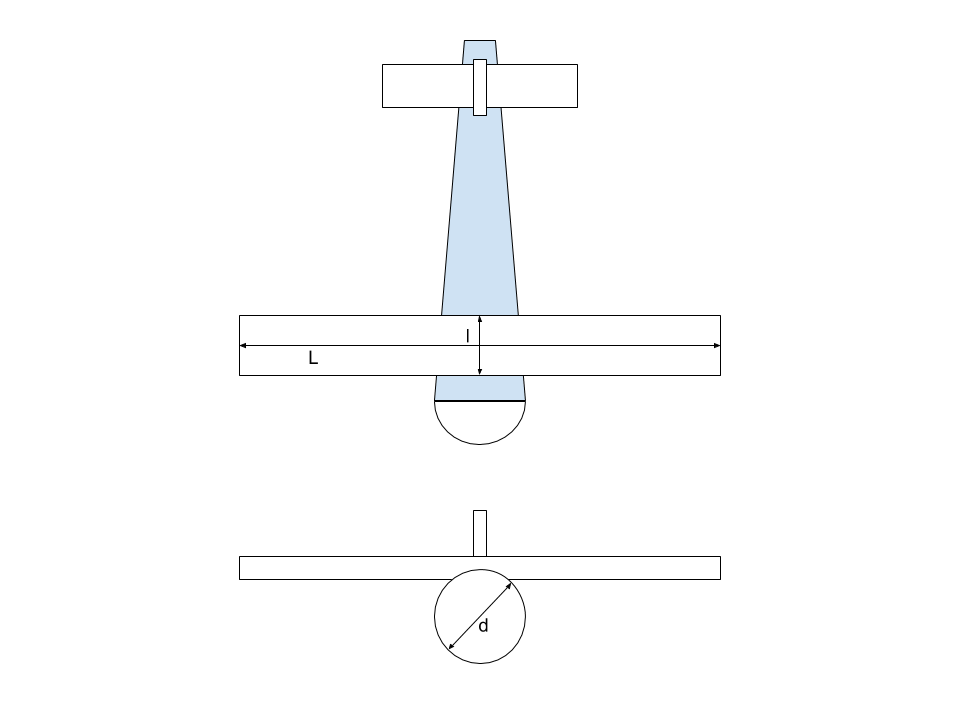

## Grandeur du problème

$S [m^2]$ : Surface de l'aile

$V [\frac{m}{s}]$ : Vitesse du vent relatif

$C_l$: Coefficient de portance (Lift en anglais)

$C_d$: Coefficient de trainée (Drague en anglais)

$C_x$: Coefficient de trainée pour une sphère à $Re > 10^3$

$l [m]$ : longueur à la corde

$L [m]$: envergure de l'aile

$d [m]$: diamétre du corps central

$\nu [\frac{m^2}{s}]$: viscosité dynamique de l'air

$g [\frac{m}{s^2}]$ : gravité

$\rho_{air} [\frac{kg}{m^3}]:$ densité de l'air

$\rho_{abs} [\frac{kg}{m^3}]:$ densité du plastique

$W_{***} [kg]:$ Masse

In [3]:
# Nature properties (Immutable)
Cx = 0.5
rho_air = 1.225
rho_abs = 1195 * 0.2 # 1.195 g/cm3 with 20% density
nu = 1.5e-5
g = 9.81

In [4]:
# Plan properties
Wfix = 0.5 # Masse en dehors de l'aile batterie, moteur, corps, ...
# Simulation properties
alpha_range = np.arange(0, 9, 1)

# Collecte d'information et de donnée sur internet

[Très bon cours sur les bases de l'aéromodelisme](http://www.xflr5.com/docs/Survol_Bases_Aero_et_XFLR5.pdf)

## Simulation des coefficients de vol

D'après le lien en haut XFLR5 est un outil très puissant est compliqué, utlisé pour faire des simulations poussées en 3D. Pour des simulations plus simple en 2D, il conseille Xfoil. Ca tombe bien car comme on utilise une aile standard, un très bon site donne directement les résultats de simulation. [Site avec simulations](http://airfoiltools.com)

Les résultats de simulations sont téléchargés dans ce dossier avec le nombre de Reynold comme nom de fichier. Ex 50k.csv = simulation avec 50 000 Re

In [5]:
rek = [50, 100, 200, 500, 1000]
data = {}
for r in rek: # name file
  data[r] = pd.read_csv('{}k.csv'.format(r), sep=',')

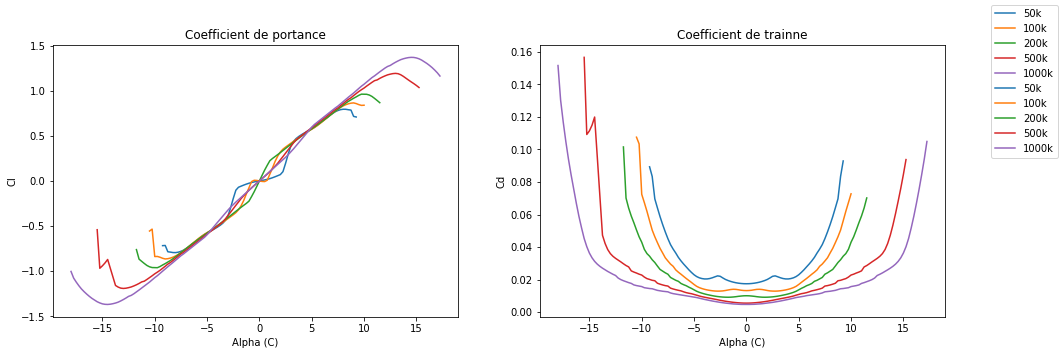

In [6]:
fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
for re in rek:
  left.plot(data[re]['alpha'], data[re]['CL'], label='{}k'.format(re))
  right.plot(data[re]['alpha'], data[re]['CD'], label='{}k'.format(re))

left.set_title('Coefficient de portance')
left.set_xlabel('Alpha (C)')
left.set_ylabel('Cl')

right.set_title('Coefficient de trainne')
right.set_xlabel('Alpha (C)')
right.set_ylabel('Cd')

fig.legend()
plt.show()

# Resolution du problème

Le but est de finir avec la fonction $Lift(F_{traction}, \alpha)$

## Construit $C_l (\alpha)$ et $C_d(\alpha)$

Reynold number = $Re = \frac{V l}{\nu}$

In [7]:
def reynolds(V, l):
  return V * l / nu

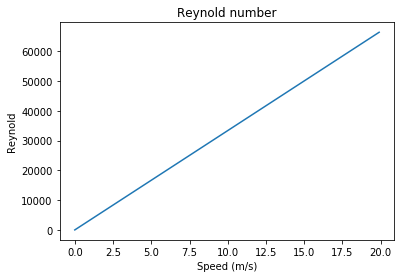

In [8]:
# On se place entre une vitesse de 0 à 20 m/S
V_range = np.arange(0, 20, 0.1)
fig, ax = plt.subplots()
ax.plot(V_range, reynolds(V_range, 0.05))
ax.set_title('Reynold number')
ax.set_xlabel('Speed (m/s)')
ax.set_ylabel('Reynold')
plt.show()

On peut juste se content des courbes avec 50k

In [9]:
Cl = interp1d(data[50]['alpha'], data[50]['CL'], kind='quadratic')
Cd = interp1d(data[50]['alpha'], data[50]['CD'], kind='quadratic')

## Résoudre $V(F_t, \alpha)$

### Calculer la trainée de l'avion

Trainée aile  $D_{wing} [N] = \frac{1}{2} \rho_{air} l L V^2 C_d$

In [10]:
def Dwing(V, a, l, L):
  return 0.5 * rho_air * l * L * Cd(a) * np.power(V, 2)

assert 0.00613 < Dwing(5, 5, 0.05, 0.35) < 0.00615

Trainée coprs  $D_{body} [N] = \frac{1}{2} \rho_{air} \left(\frac{d}{2}\right)^2 \pi V^2 C_x$

In [11]:
def Dbody(V, d):
  return 0.5 * rho_air * math.pi * Cx * np.power(V * d /2, 2)

assert 0.015 < Dbody(5, 0.05) < 0.016

### Calculer la masse de l'avion

Profil de l'aile: $y = 0.5 \left[0.2969 \sqrt{\left(\frac{x}{l}\right)} - 0.1260\left(\frac{x}{l}\right) - 0.3516\left(\frac{x}{l}\right)^2 + 0.2843\left(\frac{x}{l}\right)^3 - 0.1015\left(\frac{x}{l}\right)^4\right]$

In [12]:
y = lambda x, l: 0.5*(0.2969 * np.sqrt(x/l) - 0.1260*(x/l) - 0.3516*np.power(x/l, 2) + 0.2843*np.power(x/l, 3) - 0.1015*np.power(x/l, 4))

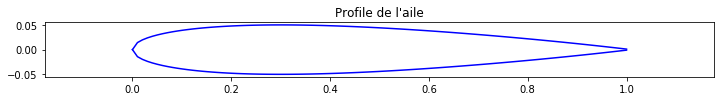

In [13]:
fig, ax = plt.subplots(figsize=(12, 1))
t = np.linspace(0, 1, 100)
ax.plot(t, y(t, 1), 'b')
ax.plot(t, -y(t, 1), 'b')
ax.set_title("Profile de l'aile")
ax.axis('equal')
plt.show()

$Area_{airfoil} = 2\int^l_0{y dx}$

In [14]:
def area(l):
  return 2 * quad(y, 0, l, args=(l,))[0]
assert 0.068 < area(1) < 0.069

Masse de l'avion $W (kg) = W_{fix} + A_{airfoil} * \rho_{abs} * L$

In [15]:
def W(l, L):
  return Wfix + area(l) * rho_abs * L
# assert 41.43 < W(1, 1) < 41.44

Poid [N] $G = W * g$

In [16]:
def gravity(l, L):
  return W(l, L) * g

### Résoudre la dynamique de l'avion

Résoudre le PFD sur l'axe de déplacement:
$$ W \frac{dV(F_t)}{dt} = F_t - D_{wing}(V(F_t), \alpha) - D_{body}(V(F_t))$$
$$\frac{dV(F_t)}{dt} = \frac{1}{W} \left[F_t - D_{wing}(V(F_t), \alpha) - D_{body}(V(F_t)) \right] $$

In [17]:
def derivate(Y, x, a, l, L, d):
  return np.array([(x - Dwing(Y[0], a, l, L) - Dbody(Y[0], d)) / W(l, L)])
# assert -5.22 < derivate([5], 1, 5, 0.05, 0.35, 0.05) < -5.21

In [18]:
def compute_speed(l, L, d, F_range):
  V = np.empty((len(alpha_range), len(F_range)), dtype=float)
  for i in range(V.shape[0]):
    V[i] = odeint(derivate, [0], F_range, args=(alpha_range[i],l, L, d)).reshape(len(F_range))
  return V

## Calculer la portance $L(F_m, \alpha)$

Portance [N] $L = \frac{1}{2} \rho_{air} S V^2 C_l$

In [19]:
def lift_eq(l, L, V, a):
  return 0.5 * rho_air * l * L * np.power(V, 2) * Cl(a)

assert 1.41 < lift_eq(1, 1, 2, 5) < 1.42

In [20]:
def build_lift(l, L, d, F_range):
  """Return Lift(alpha, F)"""
  V = compute_speed(l, L, d, F_range)
  P = np.empty_like(V)
  
  for i in range(P.shape[0]):
    P[i] = lift_eq(l, L, V[i], alpha_range[i])
  
  return interp2d(F_range, alpha_range, P)

### Final plot

In [21]:
def plot_lift(l, L, d, F_max):
  F_range = np.arange(0, F_max, 0.2)
  lift = build_lift(l, L, d, F_range)
  
  fig, ax = plt.subplots(figsize=(12, 8))
  
  ax.plot(F_range, gravity(l, L)*np.ones_like(F_range), '--', label='weight')
  
  for a in alpha_range:
    ax.plot(F_range, [lift(F, a) for F in F_range], label='a={}'.format(a))
  
  ax.set_xlabel('Force de traction N')
  ax.set_ylabel('Force de portance N')
  ax.set_title('Force de portance en fonction Force de Traction \n l={}, L={}, d={}'.format(l, L, d))
  
  fig.legend()
  plt.show()

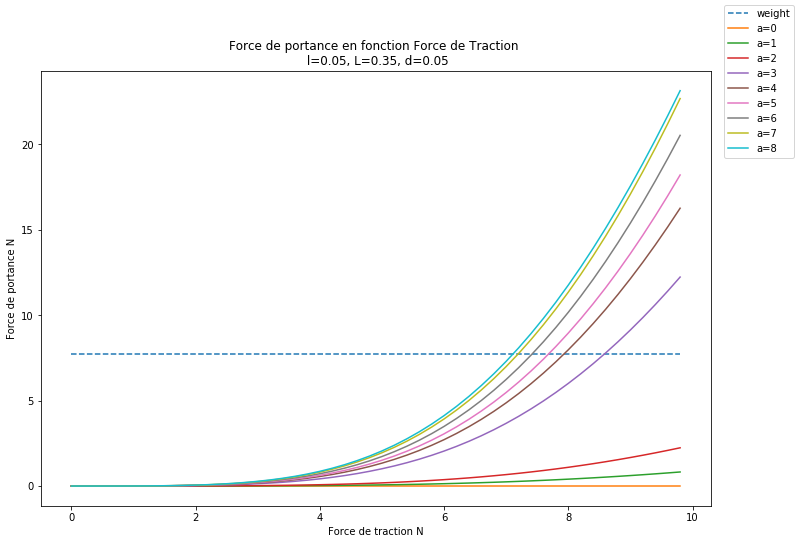

In [22]:
plot_lift(l=0.05, L=0.35, d=0.05, F_max=10)

# Optimization

In [23]:
def compute_max_lift(l, L, d, F_max):
  F_range = np.arange(0, F_max, 0.2)
  lift = build_lift(l, L, d, F_range)
  
  max_values = []
  for a in alpha_range:
    m = np.max([lift(F, a) for F in F_range])
    max_values.append(m)
  return np.mean(max_values)

Fonction à minimizer $f(l, L) = \frac{W(l, L)}{\max{lift(l, L, 0.05, 6)}}$

In [24]:
def optimize_plane(x):
  return W(x[0], x[1]) / compute_max_lift(l=x[0], L=x[1], d=0.05, F_max=6)

In [25]:
res = minimize(optimize_plane, [0.3, 1], method='SLSQP', bounds=((0, 0.3), (0, 1)))

/home/fifou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.
/home/fifou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  


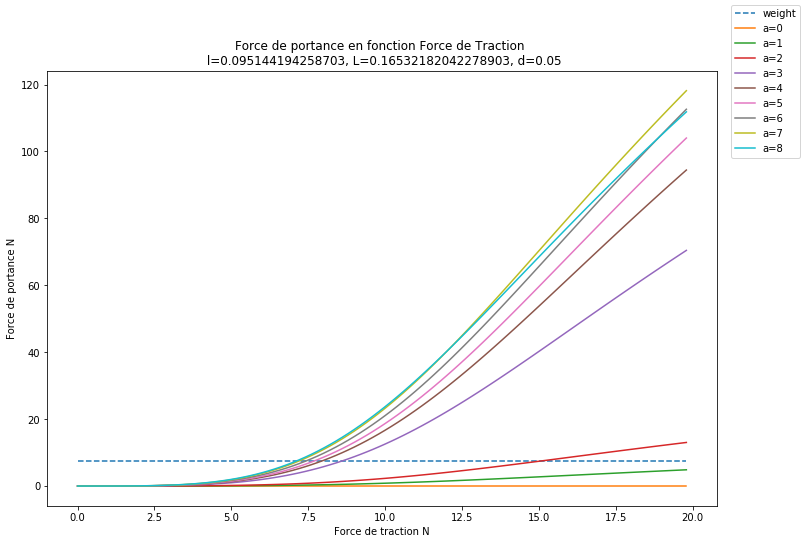

In [26]:
plot_lift(l=res.x[0], L=res.x[1], d=0.05, F_max=20)